In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [36]:
from keras.datasets import mnist

# Load MNIST
(X_mnist, y_mnist), (_, _) = mnist.load_data()

# Normalize and reshape
X_mnist = X_mnist.astype("float32") / 255
X_mnist = np.expand_dims(X_mnist, axis=-1)

print("MNIST digits loaded:", X_mnist.shape, y_mnist.shape)

MNIST digits loaded: (60000, 28, 28, 1) (60000,)


In [37]:
data_dir = "data"
img_size = 28

# Symbols ONLY (filters out digit folders 0-9)
symbol_labels = sorted([d for d in os.listdir(data_dir) if not d.isdigit()])

# get all symbol folder names
symbol_to_index = {label: idx + 10 for idx, label in enumerate(symbol_labels)}  # start from 10

# Human-readable mapping
index_to_label = {i: str(i) for i in range(10)}
index_to_label.update({v: k for k, v in symbol_to_index.items()})

X_symbols, y_symbols = [], []

# Loop trough each label folder and load images
for label in symbol_labels:
    folder_path = os.path.join(data_dir, label)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            try:
                img_path = os.path.join(folder_path, file)
                img = load_img(img_path, color_mode="grayscale", target_size=(img_size, img_size))
                img = img_to_array(img) / 255.0
                X_symbols.append(img)
                y_symbols.append(symbol_to_index[label])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Converting to Numpy arrays
X_symbols = np.array(X_symbols)
y_symbols = np.array(y_symbols)

# Sanity check
assert len(X_symbols) == len(y_symbols), f"Mismatch: {len(X_symbols)} images vs {len(y_symbols)} labels"

print("Custom symbols loaded:", X_symbols.shape, y_symbols.shape)
print("Digits:", X_mnist.shape, y_mnist.shape)
print("Symbols:", X_symbols.shape, y_symbols.shape)


Custom symbols loaded: (106379, 28, 28, 1) (106379,)
Digits: (60000, 28, 28, 1) (60000,)
Symbols: (106379, 28, 28, 1) (106379,)


In [38]:
# Fusion dance digits with operators
X_all = np.concatenate([X_mnist, X_symbols], axis=0)
y_all = np.concatenate([y_mnist, y_symbols], axis=0)

print("Unified dataset (raw):", X_all.shape, y_all.shape)

# Remap labels to continuous indices ---
unique_labels = sorted(set(y_all))

# Old to new index
label_to_newindex = {old: new for new, old in enumerate(unique_labels)}

# New index to human-readable label
newindex_to_label = {new: index_to_label[old] for old, new in label_to_newindex.items()}

# Apply mapping
y_all_mapped = np.array([label_to_newindex[y] for y in y_all])

# Sanity check
assert X_all.shape[0] == y_all_mapped.shape[0], "Mismatch after remapping"

print("Final dataset:", X_all.shape, y_all_mapped.shape)
print("Number of classes:", len(unique_labels))
print("Class mapping:", newindex_to_label)


Unified dataset (raw): (166379, 28, 28, 1) (166379,)
Final dataset: (166379, 28, 28, 1) (166379,)
Number of classes: 21
Class mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '!', 11: '(', 12: ')', 13: '+', 14: ',', 15: '-', 16: '=', 17: '[', 18: ']', 19: '{', 20: '}'}


In [39]:
# Flatten images
X_flat = X_all.reshape(X_all.shape[0], -1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_all_mapped, test_size=0.2, random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (133103, 784) (133103,)
Test set: (33276, 784) (33276,)


In [40]:
# Randomsearch param
param_dist = {
    "n_estimators": randint(50, 200),
    "max_depth": [None, 10, 20, 30],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

# Init base model
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Fit with training data
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# Use the best one dummy
rf_clf = random_search.best_estimator_

# Eval on test set
y_pred = rf_clf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n",
      classification_report(y_test, y_pred,
                            target_names=[newindex_to_label[i] for i in sorted(newindex_to_label)]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sympy import sympify

In [27]:
def segment_expression(img_path, img_size=28, show_steps=False):
    """
    Takes an image of a math expression (2 + 2),
    segments characters, and returns a list of preprocessed images.
    """

    # Load
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Inverts so white on black
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    symbol_imgs = []
    bounding_boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        roi = thresh[y:y + h, x:x + w]

        # 28x28
        roi_resized = cv2.resize(roi, (img_size, img_size), interpolation=cv2.INTER_AREA)

        # match with training data
        roi_resized = roi_resized.astype("float32") / 255.0
        roi_resized = np.expand_dims(roi_resized, axis=-1)

        symbol_imgs.append(roi_resized)
        bounding_boxes.append((x, y, w, h))

    # Sort left to right using x coordinate
    sorted_symbols = [s for _, s in sorted(zip(bounding_boxes, symbol_imgs), key=lambda b: b[0][0])]

    if show_steps:
        plt.imshow(thresh, cmap="gray")
        plt.title("Thresholded image")
        plt.show()

        for i, s in enumerate(sorted_symbols):
            plt.subplot(1, len(sorted_symbols), i + 1)
            plt.imshow(s.squeeze(), cmap="gray")
            plt.axis("off")
        plt.show()

    return sorted_symbols

In [28]:
from sympy import sympify

def solve_expression(expr):
    """
    Safely evaluate a math expression string.
    Uses sympy to avoid Python's eval() risks.
    """
    try:
        result = sympify(expr).evalf()  # sympy safely parses the math expression
        return result
    except Exception as e:
        return f"Error solving expression: {e}"


In [29]:
def predict_symbol_rf(img):
    """
    img: numpy array shape (28,28,1), normalized [0,1]
    returns: predicted label (digit or operator)
    """
    img_flat = img.reshape(1, -1)  # flatten to match RF training input
    pred_idx = rf_clf.predict(img_flat)[0]  # rf_clf must be trained already
    return newindex_to_label[pred_idx]

In [30]:
def classify_expression(img_path):
    """
    Segment and classify an expression image into a string
    """
    symbols = segment_expression(img_path, img_size=28, show_steps=True)

    predicted_chars = [predict_symbol_rf(s) for s in symbols]

    expression = "".join(predicted_chars)
    return expression

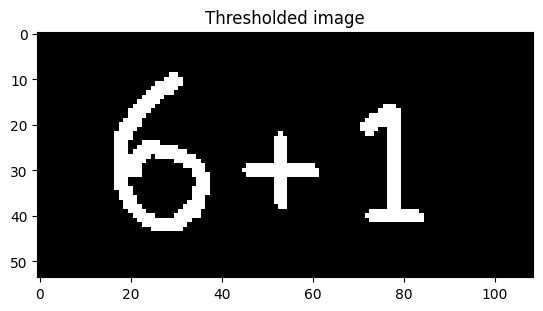

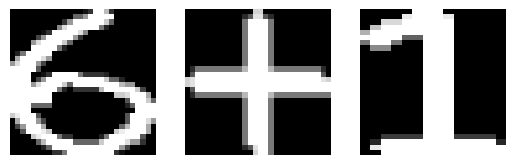

Recognized expression: 441
Result: 441.000000000000


In [32]:
# Example: feed an image of "2+2"
expr_img = "test_images/math_img.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solve_expression(expr_str)
print("Result:", result)
